In [392]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from matplotlib import patches as mpatches
import seaborn as sns

# Read in the data
data_path = ('/Users/ebotiabarbera/Desktop/TRABAJO/frontline_test/')
df_raw = pd.read_csv(data_path + 'Frontline Test.csv')

# Check the data
df_raw.head()

,ID,Task Name,Duration,Start,Finish,Predecessors,% Work Complete,Work,Resource Names
0,2,Equiment Spadework 1,8 days,4/24/2023 8:00,5/3/2023 17:00,NaN,100%,204.8 hrs,General Fitter
1,3,Prep top cover and elbow / Manhole cover removal,9 days,5/4/2023 8:00,5/16/2023 17:00,2,100%,230.4 hrs,Pipe Fitter
2,4,Lift Cover and elbow,1 day,5/17/2023 8:00,5/17/2023 17:00,3,100%,0 hrs,Crane Operator
3,5,Remove demister,4 days,5/18/2023 8:00,5/23/2023 17:00,"4,2",0%,102.4 hrs,General Fitter
4,6,Set up ventilation,2 days,5/24/2023 8:00,5/25/2023 17:00,5,0%,25.6 hrs,General Fitter


In [393]:
def data_preprocessing(df):
    df = df.copy()
    # convert 'Task Name' to lower case
    df['Task Name'] = df['Task Name'].str.lower()
    # drop rows with missing values in 'Duration' column
    df = df.dropna(subset=['Duration'])
    # convert 'Duration' to int by removing the 'day(s)' string
    df['Duration'] = df['Duration'].str.rstrip('days').astype('int')
    # convert 'Start' and 'Finish' from 'm/dd/yyyy h:mm'format to datetime
    df['Start'] = pd.to_datetime(df['Start'], format='%m/%d/%Y %H:%M')
    df['Finish'] = pd.to_datetime(df['Finish'], format='%m/%d/%Y %H:%M')
    df = df.sort_values(by=['Start', 'Finish'], ascending=False).reset_index(drop=True)
    # convert 'Predecessors' to list of integers
    df['Predecessors'] = df['Predecessors'].str.split(',').fillna('')
    df['Predecessors'] = df['Predecessors'].apply(lambda x: [int(i) if i != '' else [] for i in x])
    # convert '% Work Complete' to float by removing the '%' string
    df['% Work Complete'] = df['% Work Complete'].str.rstrip('%').astype('float') / 100.0
    # convert 'Work' to float by removing the 'hrs' string
    df['Work'] = df['Work'].str.rstrip('hrs').astype('float')
    return df

df = data_preprocessing(df_raw)
df.head()

,ID,Task Name,Duration,Start,Finish,Predecessors,% Work Complete,Work,Resource Names
0,32,"fuse in, loto out",9,2023-09-29 08:00:00,2023-10-11 17:00:00,[31],0.0,288.0,General Fitter
1,31,spade out,9,2023-09-18 08:00:00,2023-09-28 17:00:00,[30],0.0,288.0,Pipe Fitter
2,30,couple back with motor,9,2023-09-05 08:00:00,2023-09-15 17:00:00,[28],0.0,288.0,General Fitter
3,29,alignment,27,2023-08-23 08:00:00,2023-09-28 17:00:00,[27],0.0,864.0,General Fitter
4,28,install pump,9,2023-08-23 08:00:00,2023-09-04 17:00:00,[27],0.0,288.0,General Fitter


In [365]:
# compute the project duration
project_duration = df['Finish'].max() - df['Start'].min()
print("Project Duration: {} (days)".format(project_duration.days))
# compute the nuber of different resources
n_resources = df['Resource Names'].nunique()
print("Number of Resources: {}".format(n_resources))
# compute the number of different tasks
n_tasks = df['ID'].nunique()
print("Number of Tasks: {}".format(n_tasks))
# compute the Remaining Work (% of (remaining work hours)/(total project work hours))
df['Remaining Work'] = (1 - df['% Work Complete']) * df['Work']
remaining_work = df['Remaining Work'].sum() / df['Work'].sum() * 100
print("Remaining Work: {}%".format(round(remaining_work, 2)))

Project Duration: 170 (days)
Number of Resources: 7
Number of Tasks: 77
Remaining Work: 94.45%


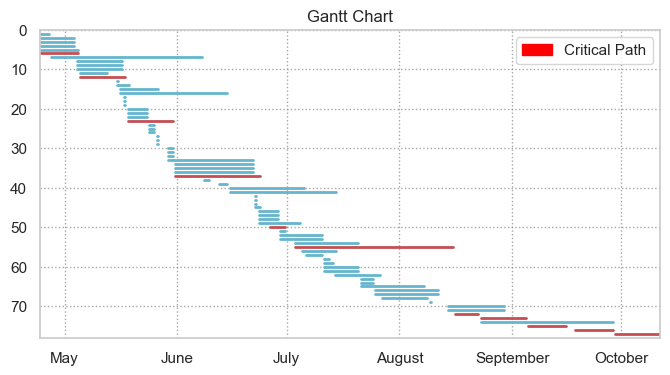

In [440]:
def gantt_chart(df):
    """Plot a Gantt chart from a dataframe.
    
    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with the following columns: 'ID', 'Start', 'Finish' and 'Predecessors'.
    """
    # compute critical path
    df = df[['ID', 'Start', 'Finish', 'Predecessors']].copy()
    df['Critical Path'] = False
    df.loc[0, 'Critical Path'] = True
    for i in range(len(df)):
        if df.loc[i, 'Critical Path']:
            for j in df.loc[i, 'Predecessors']:
                df.loc[df["ID"]==j, 'Critical Path'] = True
    # Create figure and axis
    _, ax = plt.subplots(figsize=(8, 4))
    # Set title and axis labels
    ax.set_title("Gantt Chart")
    # Set axis limits
    ax.set_xlim(df['Start'].min(), df['Finish'].max())
    ax.set_ylim(0, len(df) + 1)
    # Format the y-axis
    ax.set_yticks(np.arange(len(df) + 1, 0, -10))
    ax.set_yticklabels(np.arange(0, len(df) - len(df)%10 + 1, 10))
    # Format the x-axis
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
    # Plot the grid
    ax.grid(axis='x', color='gray', linestyle='dotted', linewidth=1, alpha=0.7)
    ax.grid(axis='y', color='gray', linestyle='dotted', linewidth=1, alpha=0.7)
    # Plot the bars
    for task, start, finish in zip(df.index+1, df['Start'], df['Finish']):
        task_color = 'r' if df.loc[task - 1, 'Critical Path'] else 'c'
        ax.plot([start, finish], [task, task], color=task_color, linewidth=2)
    # Create a legend
    red_patch = mpatches.Patch(color='red', label='Critical Path')
    plt.legend(handles=[red_patch])
    # Show the plot
    plt.show()

# plot the Gantt chart
gantt_chart(df)

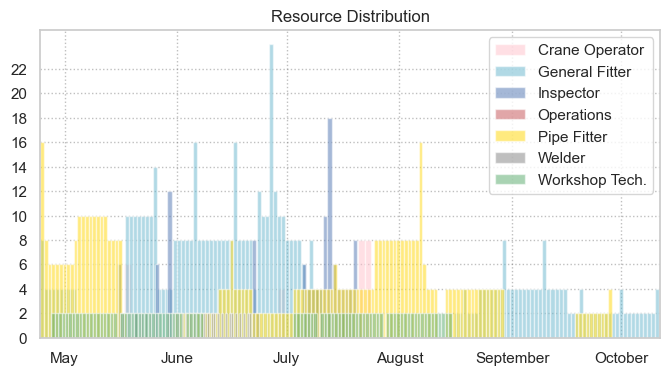

In [445]:
def resource_distribution(df):
    """
    Plots in the same axis the histograms of the number tasks per day among the different resources 
    (overlapping the distributions with opacity) with total time range in the x-axis.
    """
    # create a new dataframe with the start and finish dates of each task
    df_dates = pd.DataFrame(columns=['Resource', 'Date'])
    for i in range(len(df)):
        date_range = pd.date_range(df.loc[i, 'Start'], df.loc[i, 'Finish'], freq='D')
        # get the resource name
        resource = df.loc[i, 'Resource Names']
        # create a dataframe with the dates and the resource name
        for date in date_range:
            df_dates = pd.concat([df_dates, pd.DataFrame({'Resource': [resource], 'Date': [date]})])
            df_dates = pd.concat([df_dates, pd.DataFrame({'Resource': [resource], 'Date': [date]})])
    # compute the number of tasks per day for each resource
    df_dates = df_dates.groupby(['Resource', 'Date']).size().reset_index(name='Tasks')
    # plot the histogram
    _, ax = plt.subplots(figsize=(8, 4))
    ax.set_title("Resource Distribution")
    ax.set_xlim(df['Start'].min(), df['Finish'].max())
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%B'))
    ax.set_yticks(np.arange(0, max(df_dates['Tasks'])*2, 2))
    ax.set_yticklabels(np.arange(0, max(df_dates['Tasks'])*2, 2))
    ax.grid(axis='x', color='gray', linestyle='dotted', linewidth=1, alpha=0.5)
    ax.grid(axis='y', color='gray', linestyle='dotted', linewidth=1, alpha=0.5)
    colors = ['pink', 'c', 'b', 'r', 'gold', 'gray', 'g']
    for i, resource in enumerate(df_dates['Resource'].unique()):
        df_resource = df_dates[df_dates['Resource'] == resource]
        col = colors[i] if len(df_dates['Resource'].unique()) == len(colors) else None
        ax.hist(df_resource['Date'], weights=df_resource['Tasks'], bins=len(df_resource)+30, alpha=0.5, label=resource, color=col)
    ax.legend()
    plt.show()

resource_distribution(df);